## Tutorial #1: Loading EEG Data

#### This tutorial focuses on loading different representations of EEG data.  

To import data into python, we will use functions of the [MNE package](https://mne.tools/dev/index.html). MNE is an open-source Python package for exploring, visualizing, and analyzing human neurophysiological data. 

EEG data can be considered in 3 different types: raw data, epoched data and evoked (averaged) data.

1. Raw Data: Continuous data is stored as a raw object in MNE. Data in a raw object are considered as a 2D array with dimensions of channels×time.
   
2. Epoched Data: This consists of time-locked trials. Data are a 3D array of events×channels×times.

3. Average Event Related Potentials: This is the result of averaging epoched data over trials. The output is time-locked to an external event, and it is stored as a 2D array of channels×times.

In [2]:
import mne

### 1.1) Loading datasets available in MNE: EEGBCI motor imagery Dataset


We start with a dataset that is already available in the MNE package (EEGBI motor imagery dataset). The dataset contains 64-channel EEG recordings from 109 participants and 14 runs on each participant in EDF+ format. For more details please check https://www.nmr.mgh.harvard.edu/mne/stable/manual/datasets_index.html#eegbci-motor-imagery. 

In order to load a dataset in MNE, we need to provide a participant id or a list of participant ids, a list of runs (tasks) and path to locate data should be provided as arguments to load_data() function. 

The function load_data() returns a list of paths that the requested data files located. 

Another way to load data is by using the read_raw_edf() function. This will load downloaded edf files and concatenate the raw data in each edf file to have the final dataset with all the selected runs.

In [3]:
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf

#Define the parameters 
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # use only hand and feet motor imagery runs

#Get data and locate in to given path
files = eegbci.load_data(subject, runs, '../datasets/')
#Read raw data files where each file contains a run
raws = [read_raw_edf(f, preload=True) for f in files]
#Combine all loaded runs
raw_obj = concatenate_raws(raws)

[........................................] 100.00% (  2.5 MB,  20.4 MB/s) |   
Do you want to set the path:
    /data/Athina/AlgorithmsNeuroscience/datasets
as the default EEGBCI dataset path in the mne-python config [y]/n? y
[........................................] 100.00% (  2.5 MB,  17.1 MB/s) -   
[........................................] 100.00% (  2.5 MB,  13.8 MB/s) /   
Extracting EDF parameters from /data/Athina/AlgorithmsNeuroscience/datasets/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /data/Athina/AlgorithmsNeuroscience/datasets/MNE-eegbci-data/physiobank/database/eegmmidb/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /data/Athina/AlgorithmsNe

All data structures such as raw and epochs in mne have an attribute named 'info' which provides measurement related information about a given dataset.  

Raw data are stored in 2D array, containing channels×samples. The data can be accessed as following:

In [6]:
raw_data = raw_obj.get_data()

# OR

raw_data = raw_obj._data

print("Number of channels: ", str(len(raw_data)))
print("Number of samples: ", str(len(raw_data[0])))

Number of channels:  64
Number of samples:  60000


The imported raw EEG signal will simply contain time-courses of EEG activity, one per electrode. 

For example, we can visualize the time-course EEG activity over the first electrode, during 5000 samples:

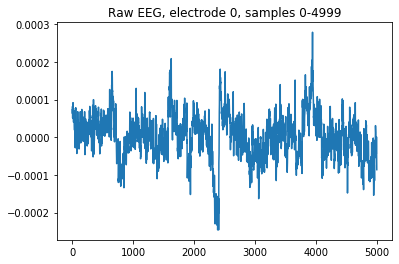

In [14]:
import matplotlib.pyplot as plt

plt.plot(raw_data[0,:4999])
plt.title("Raw EEG, electrode 0, samples 0-4999")
plt.show()

##### Converting Raw data to Epoched data

A raw EEG file contains continuous activity of EEG signals, recorded over a period of time. Very often, we use EEG to analyze neural responses to external events of the environment. For example, we may want to study how the brain responds to a set of images, or sounds. For this reason, instead of analyzing a continuous time-course of activity, we want to focus on *parts* of the EEG signals, which correspond to the time when external events occured.

Typically, during an experiment we mark the time when important events occur by integrating *triggers* into an EEG recording, which can be imported as 'Events'. 
An 'Event' will essentially give us information of *when* in time an external stimulus was presented, and of *what* this stimulus was. 

Once we have this information, we can convert our raw EEG signal to Epochs. This consists of extracting chunks of EEG data around a given window, marked by the time when each external event occured. 

To do this conversion in python, we first need to read a file of external events. If the data is annotated, then the events can be extracted easily by event_from_annotations() function of MNE. The function will return both events and event ids.  

In [15]:
#Extract events from raw data
events, event_ids = mne.events_from_annotations(raw_obj, event_id='auto')
event_ids

Used Annotations descriptions: ['T0', 'T1', 'T2']


{'T0': 1, 'T1': 2, 'T2': 3}

### How do we select the time interval that we want to analyze?

To be able to define epochs in our EEG data, a time interval of interest should be selected. 

tmin and tmax represent the beginning and the end of selected time interval (in seconds). This selection may differ, depending on the experiment. If the reponse to the given stimuli is expected to happen quickly, then a narrow time interval may be needed and vice versa. 

For example, if our goal is to study basic sensory processing, e.g. resposnes to simple visual or auditory stimuli, then we expect EEG responses to appear relatively early i.e. within a few hundrend miliseconds after the onset of the stimuli. If by contrast our goal is to study higher cognitive functions, e.g. mental imagery, or decision-making, we will very likely need to extract a longer interval in order to capture the relevant EEG responses. 

In the following example, we define epochs lasting for 4 seconds after the event onset.

As it is typical in EEG analysis, we also define a baseline, i.e. an interval of relative 'inactivity'. Post-stimulus responses are typically contrasted with respect to this baseline.


In [16]:
tmin, tmax = -1, 4  # define epochs around events (in s)
#event_ids = dict(hands=2, feet=3)  # map event IDs to tasks

epochs = mne.Epochs(raw_obj, events, event_ids, tmin - 0.5, tmax + 0.5, baseline=None, preload=True)

90 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
Loading data for 90 events and 961 original time points ...
3 bad epochs dropped


As you observe, in the above example we annotate 'baseline = None', which simply indicates that no baseline correction is applied on the data. As our 'tmin' is -1 (negative), the extracted epochs will contain a baseline period. It is then up to us to decide whether we want to use this period for baseline correction.

Accessing data of an epochs object is being done by the same ways as for raw objcets.

In [17]:
#Access to the data
data = epochs._data

n_events = len(data) # or len(epochs.events)
print("Number of events: " + str(n_events)) 

n_channels = len(data[0,:]) # or len(epochs.ch_names)
print("Number of channels: " + str(n_channels))

n_times = len(data[0,0,:]) # or len(epochs.times)
print("Number of time instances: " + str(n_times))

Number of events: 87
Number of channels: 64
Number of time instances: 961


The epoched data are still time-courses of EEG activity, over electrodes, but now we also have an additional dimension of epochs. Here is an example of a few epochs, plotted here:

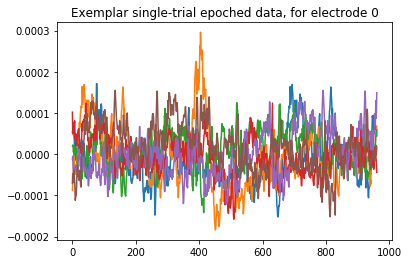

In [25]:
plt.plot(data[14:20,0,:].T)
plt.title("Exemplar single-trial epoched data, for electrode 0")
plt.show()

### 1.2) Loading EEG data

EEG data can be loaded directly from a given path.
If the data are already epoched, the function mne.read_epochs() can be used for reading epoched data from a '.fif' file: 

In [26]:
## Loading Epoched data 

# The file name should end with'-epo.fif':
data_file = '../datasets/817_1_PDDys_ODDBALL_Clean_curated-epo'

# Read the EEG epochs:
epochs = mne.read_epochs(data_file + '.fif', verbose='error')

Reading ../datasets/817_1_PDDys_ODDBALL_Clean_curated-epo.fif ...
    Found the data of interest:
        t =    -100.00 ...     500.00 ms
        0 CTF compensation matrices available
189 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


When reading data as epochs, these will be stored in a 3D array. To access the data of this array you can use two different ways:

In [27]:
## Accessing to the data

# The data can be accessed via:
epochs_data_1 = epochs._data
#or 
epochs_data_2 = epochs.get_data()

#To check whether the two different ways returns the same data
if epochs_data_1.all() == epochs_data_2.all():
    print("Output: Same data!")
else:
    print("Output: Data is not the same!")
        

Output: Same data!


The labels of experimental conditions are stored into a dictionary, accessed as:

In [28]:
epochs.event_id

{'Novel': 202, 'Standard': 201, 'Target': 200}

To access epochs that belong to a specific experimental condition, you can simply refer to their label as following:

In [29]:
novels = epochs['Novel']

In [30]:
tmin = epochs.tmin
tmax = epochs.tmax

print('Start time before the event' , tmin)
print('Stop time after the event' , tmax)

Start time before the event -0.1
Stop time after the event 0.5


##### Obtain average ERP data from epoched data

Average Event-Related Potentials are produced by averaging all available epochs:

In [31]:
evoked = epochs.average()

When averaging epochs, the total number of channels and the number of time points do not change, since the averaging is done over trials. This leaves us with a 2D array, where the first dimension is channels and the second time:

In [36]:
evoked_data = evoked.data
n_channels = len(evoked_data) # or len(evoked.ch_names)
print("Number of channels: " + str(n_channels))

n_times = len(evoked_data[0,:]) # or len(evoked.times)
print("Number of time instances: " + str(n_times))

Number of channels: 60
Number of time instances: 301


Again, we can visualize the averaged epochs for the first electrode. Compared to the single-trial epochs, the averaged ones are much smoother:

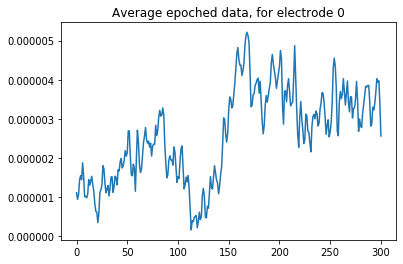

In [37]:
plt.plot(evoked._data[0,:].T)
plt.title("Average epoched data, for electrode 0")
plt.show()